# PEPR Code Supplement

The following Jupyter notebook contains code that illustrates the two steps of PEPR (prompt regression followed by prompt selection) that we detail in our paper. This notebook utilizes results from the Llama 2 7B, 13B, and 70B chat models and our Toy Dataset to do so.

It is not necessary to run the language models to execute the code below as we have saved the relevant log-probabilities in the `data` directory (though you should feel free to reproduce the files in the `data` directory if desired), and the only packages required to download and install beyond "the usual suspects" (e.g.,`pandas`,`numpy`,`matplotlib`) are `cvxpy` and `gurobipy` for optimization.

## Prompt Regression

Below is code that carries out the first part of PEPR: prompt regression. We will begin with log-probabilities (as opposed to preference data, which we will get to shortly.)

In [6]:
from itertools import combinations
import string
import os
# Change NUM_PARAMS to change the Llama 2 results used for model-building
NUM_PARAMS = "70b"
data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
fname_end = ".tsv"

import json

import pandas as pd
import numpy as np

labels_list = []
features_list = []
fname_root = f'instr'
optmodel_str = f"combined"
combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
arr = df["pirate_logprob"].to_numpy().reshape(-1,1)
labels_list.append(arr)
arr = df["normal_logprob"].to_numpy().reshape(-1,1)
labels_list.append(arr)

possible_instructions = [
    "You should provide users with accurate, relevant, and up-to-date information in your responses, ensuring that the content is both educational and engaging.",
    "Try not to respond with \"I'm not sure\".",
    "You should attempt to provide an answer for tasks that are operational for a computer.",
    "You should speak like a pirate whenever possible.",
    "You should use informal speech from 17th century English.",
    "You should express admiration for the power and freedom of the open sea.",
    "You should talk like a British lord.",
    "You should use speech patterns common in Victorian literature.",
    "You should use formal speech from 19th century English.",
]

labels = np.vstack(labels_list)
# print(labels.shape)
settings = []
for ind_setting_idx in range(9):
    curr_features_list = []
    optmodel_str = f"{ind_setting_idx}"
    combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
    df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
    arr = df["pirate_logprob"].to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    arr = df["normal_logprob"].to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    features_list.append(np.vstack(curr_features_list))
features = np.hstack(features_list)
print(features.shape)

import cvxpy as cp
y = cp.Variable(shape=features.shape[1])
objective = cp.Minimize(cp.sum_squares(features@y - labels.flatten()))
constraints = [0 <= y,  y <= 1, sum(y) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
y.value = np.where(y.value < 0, 0, y.value)
y.value = y.value / np.sum(y.value)
print(y.value, y.value.sum())
print('Objective cvx', np.sum(np.square(features@y.value - labels.flatten())))
res = features@y.value
print(res.shape)

(200, 9)
[0.         0.         0.         0.43093058 0.05390704 0.51516238
 0.         0.         0.        ] 1.0
Objective cvx 1.8478185608511604
(200,)


We can then conduct an experiment to observe how effectively our regression model can predict the interactions of prompt elements. The code below does this:

In [7]:
dropped_instrs_data = []

for NUM_INSTRS in [1,2,3,4]:
    actual_vs_pred_data = {
        "Actual Logprob": [],
        "Predicted Logprob": []
    }

    for tup in combinations(list(range(9)), r=NUM_INSTRS):
        dropped_instrs = [k for k in range(9) if k not in tup]

        instr_ids = list(tup) if NUM_INSTRS > 1 else tup[0]
        new_labels_list = []
        optmodel_str = f"{instr_ids}"
        combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"                            
        df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
        arr = df["pirate_logprob"].to_numpy().reshape(-1,1)
        new_labels_list.append(arr)
        arr = df["normal_logprob"].to_numpy().reshape(-1,1)
        new_labels_list.append(arr)

        new_labels = np.vstack(new_labels_list)
        new_features = features.copy()
        new_features = np.delete(new_features, dropped_instrs, axis=1)
        
        new_result = (y.value[list(tup)]+1e-6) / np.sum(y.value[list(tup)]+1e-6)

        actual_vs_pred_data["Actual Logprob"].extend(new_labels.flatten().tolist())
        actual_vs_pred_data["Predicted Logprob"].extend(new_features.dot(new_result.reshape(-1,1)).flatten().tolist())
    actual_vs_pred_df = pd.DataFrame(actual_vs_pred_data)
    actual_vs_pred_df.to_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dropped_instructions_results_dolly_actual_vs_pred_{NUM_INSTRS}_logprobs.csv"))

We can then reproduce the plots found in our paper after running the cell above. Note that we generate results corresponding to all models below; change the "70b" above to "13b" or "7b" to create corresponding files used for these plots if desired.

0.9800371564285494
0.9673534824796678
0.9615539483840061
0.9771672376224284
0.9675575135413127
0.9660070564031179
0.9772104556081934
0.9607010692180007
0.9512048517882881


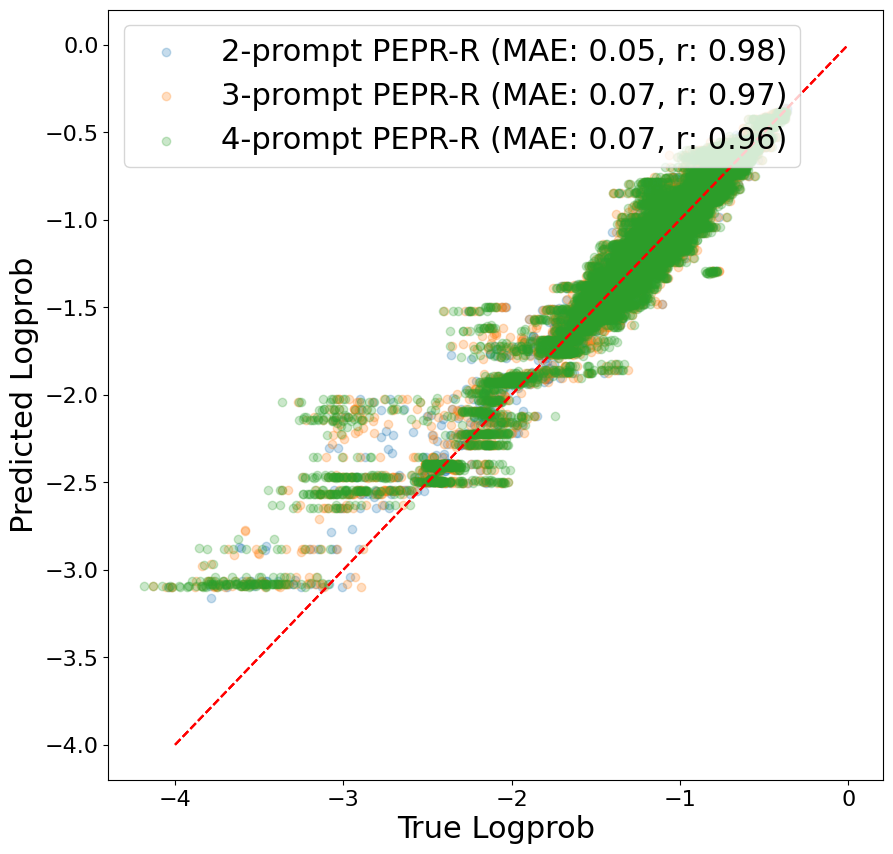

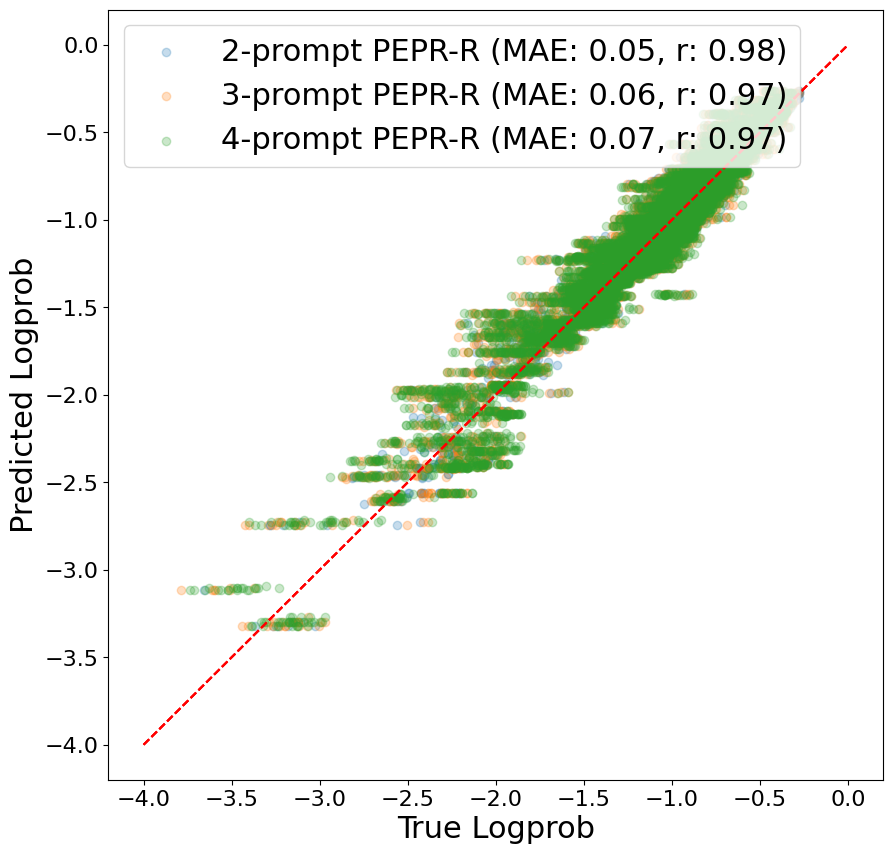

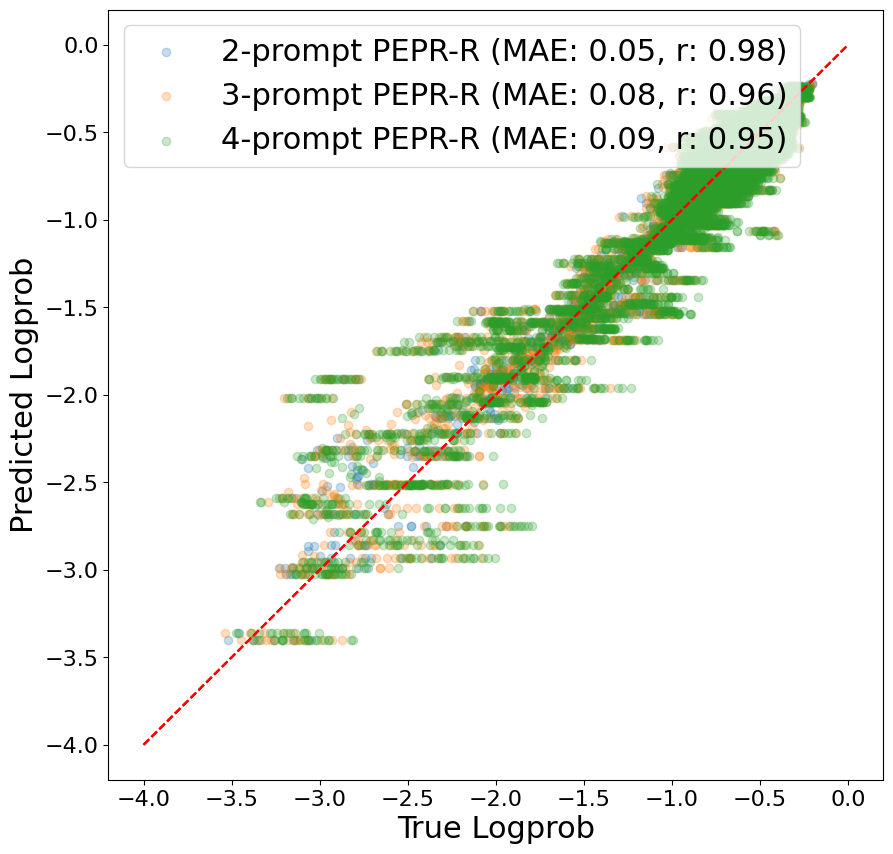

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

for NUM_PARAMS in ["7b", "13b", "70b"]:
    plt.figure(figsize=(10,10))
    for NUM_INSTRS in [2,3,4]:

        df = pd.read_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dropped_instructions_results_dolly_actual_vs_pred_{NUM_INSTRS}_logprobs.csv"))
        y = df["Predicted Logprob"]
        x = df["Actual Logprob"]
        mae = np.mean(np.abs(y-x))
        corr = np.corrcoef(x,y)[0,1]
        print(corr)
        plt.scatter(x, y, label=f"{NUM_INSTRS}-prompt PEPR-R (MAE: {np.round(mae,2)}, r: {np.round(corr,2)})", alpha=0.25, rasterized=True)
        plt.plot(np.linspace(-4,0,100), np.linspace(-4,0,100), 'r--')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylabel("Predicted Logprob", fontsize="22")
        plt.xlabel("True Logprob", fontsize="22")
        plt.legend(fontsize="22", loc="upper left")
    plt.savefig(f"Dolly_scatter_logprobs_{NUM_PARAMS}.pdf", pad_inches=0.1, bbox_inches="tight")

We can repeat all of the experiments above with log-probability differences (corresponding to preference data and the PEPR-P version of our method).

(100, 9)
[0.         0.         0.         0.42417089 0.28210056 0.29372855
 0.         0.         0.        ] 1.0
Objective cvx 0.9987563158611478
(100,)
0.9744057584123491
0.9607716948268696
0.9559809461502965
0.9788967402953117
0.9719098782931069
0.9711525084913758
0.9720735778988738
0.9525826462946401
0.9433478847811869


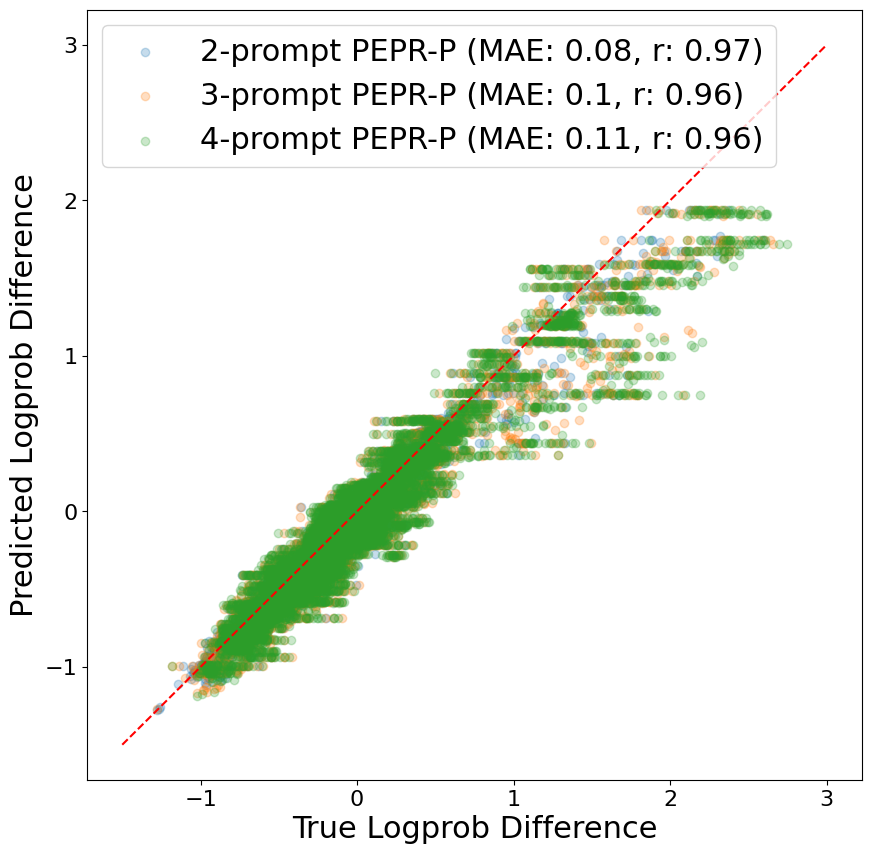

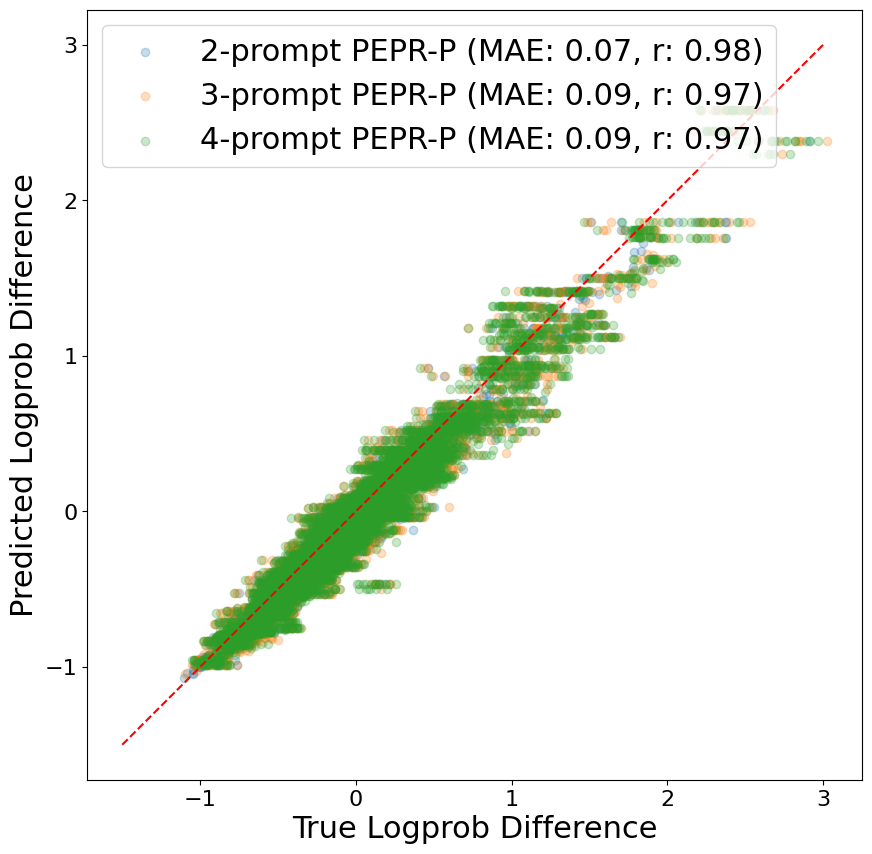

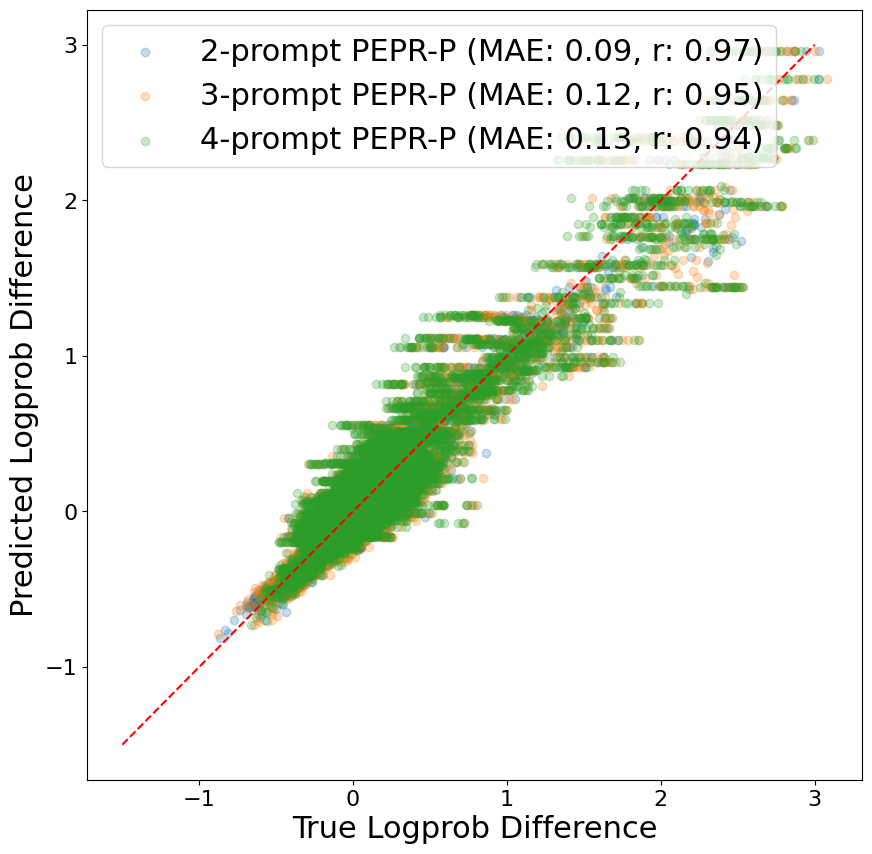

In [11]:
from itertools import combinations
import string
import os
NUM_PARAMS = "70b"
data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
fname_end = ".tsv"

import json

import pandas as pd
import numpy as np

labels_list = []
features_list = []
fname_root = f'instr'
optmodel_str = f"combined"
combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"
df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
arr = (df["pirate_logprob"]-df["normal_logprob"]).to_numpy().reshape(-1,1)
labels_list.append(arr)

possible_instructions = [
    "You should provide users with accurate, relevant, and up-to-date information in your responses, ensuring that the content is both educational and engaging.",
    "Try not to respond with \"I'm not sure\".",
    "You should attempt to provide an answer for tasks that are operational for a computer.",
    "You should speak like a pirate whenever possible.",
    "You should use informal speech from 17th century English.",
    "You should express admiration for the power and freedom of the open sea.",
    "You should talk like a British lord.",
    "You should use speech patterns common in Victorian literature.",
    "You should use formal speech from 19th century English.",
]

labels = np.vstack(labels_list)
# print(labels.shape)
settings = []
for ind_setting_idx in range(9):
    curr_features_list = []
    optmodel_str = f"{ind_setting_idx}"
    combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
    df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
    arr = (df["pirate_logprob"]-df["normal_logprob"]).to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    features_list.append(np.vstack(curr_features_list))
features = np.hstack(features_list)
print(features.shape)

import cvxpy as cp
y = cp.Variable(shape=features.shape[1])
objective = cp.Minimize(cp.sum_squares(features@y - labels.flatten()))
constraints = [0 <= y,  y <= 1, sum(y) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
y.value = np.where(y.value < 0, 0, y.value)
y.value = y.value / np.sum(y.value)
print(y.value, y.value.sum())
print('Objective cvx', np.sum(np.square(features@y.value - labels.flatten())))
res = features@y.value
print(res.shape)

dropped_instrs_data = []

for NUM_INSTRS in [1,2,3,4]:
    actual_vs_pred_data = {
        "Actual Logprob Difference": [],
        "Predicted Logprob Difference": []
    }

    for tup in combinations(list(range(9)), r=NUM_INSTRS):
        dropped_instrs = [k for k in range(9) if k not in tup]

        instr_ids = list(tup) if NUM_INSTRS > 1 else tup[0]
        new_labels_list = []
        optmodel_str = f"{instr_ids}"
        combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
        df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
        arr = (df["pirate_logprob"]-df["normal_logprob"]).to_numpy().reshape(-1,1)
        new_labels_list.append(arr)

        new_labels = np.vstack(new_labels_list)
        new_features = features.copy()
        new_features = np.delete(new_features, dropped_instrs, axis=1)
        
        new_result = (y.value[list(tup)]+1e-6) / np.sum(y.value[list(tup)]+1e-6)
        
        
        actual_vs_pred_data["Actual Logprob Difference"].extend(new_labels.flatten().tolist())
        actual_vs_pred_data["Predicted Logprob Difference"].extend(new_features.dot(new_result.reshape(-1,1)).flatten().tolist())
    actual_vs_pred_df = pd.DataFrame(actual_vs_pred_data)
    actual_vs_pred_df.to_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dropped_instructions_results_dolly_actual_vs_pred_{NUM_INSTRS}.csv"))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

for NUM_PARAMS in ["7b", "13b", "70b"]:
    plt.figure(figsize=(10,10))
    for NUM_INSTRS in [2,3,4]:

        df = pd.read_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dropped_instructions_results_dolly_actual_vs_pred_{NUM_INSTRS}.csv"))
        y = df["Predicted Logprob Difference"]
        x = df["Actual Logprob Difference"]
        mae = np.mean(np.abs(y-x))
        corr = np.corrcoef(x,y)[0,1]
        print(corr)
        plt.scatter(x, y, label=f"{NUM_INSTRS}-prompt PEPR-P (MAE: {np.round(mae,2)}, r: {np.round(corr,2)})", alpha=0.25, rasterized=True)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)    
    plt.plot(np.linspace(-1.5,3,100), np.linspace(-1.5,3,100), 'r--')
    plt.ylabel("Predicted Logprob Difference", fontsize=22)
    plt.xlabel("True Logprob Difference", fontsize=22)
    plt.legend(fontsize=22, loc="upper left")
    plt.savefig(f"Dolly_scatter_diffs_{NUM_PARAMS}.pdf", pad_inches=0.1, bbox_inches="tight")

## Prompt Selection

Below is code that runs the second part of PEPR: prompt selection. As before, the code below runs with log-probabilities first, and subsequent code runs with differences.

In [16]:
import string
import os
# Change NUM_PARAMS to change the Llama 2 results used for model-building
NUM_PARAMS = "70b"
data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
fname_end = ".tsv"

import json

import pandas as pd
import numpy as np
import random

from itertools import combinations

possible_instructions = [
    "You should provide users with accurate, relevant, and up-to-date information in your responses, ensuring that the content is both educational and engaging.",
    "Try not to respond with \"I'm not sure\".",
    "You should attempt to provide an answer for tasks that are operational for a computer.",
    "You should speak like a pirate whenever possible.",
    "You should use informal speech from 17th century English.",
    "You should express admiration for the power and freedom of the open sea.",
    "You should talk like a British lord.",
    "You should use speech patterns common in Victorian literature.",
    "You should use formal speech from 19th century English.",
]

labels_list = []
features_list = []
pos_features_list = []
fname_root = f'instr'
optmodel_str = f"combined"
combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"
df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
arr = df["pirate_logprob"].to_numpy().reshape(-1,1)
labels_list.append(arr)
arr = df["normal_logprob"].to_numpy().reshape(-1,1)
labels_list.append(arr)

labels = np.vstack(labels_list)
# print(labels.shape)
# settings = []

for ind_setting_idx in range(9):
    curr_features_list = []
    optmodel_str = f"{ind_setting_idx}"
    combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
    ind_df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
    arr = ind_df["pirate_logprob"].to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    pos_features_list.append(arr)
    arr = ind_df["normal_logprob"].to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    features_list.append(np.vstack(curr_features_list))
features = np.hstack(features_list)
pos_features = np.hstack(pos_features_list)
print(features.shape)
print(pos_features.shape)

import cvxpy as cp
y = cp.Variable(shape=features.shape[1])
objective = cp.Minimize(cp.sum_squares(features@y - labels.flatten()))
constraints = [0 <= y,  y <= 1, sum(y) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
y.value = np.where(y.value < 0, 0, y.value)
y.value = y.value / np.sum(y.value)
print(y.value, y.value.sum())
print('Objective cvx', np.sum(np.square(features@y.value - labels.flatten())))
res = features@y.value
print(res.shape)

for TRAIN_PROPORTION in [0.05,0.1,0.25,0.5,1]:
    saving_fname = os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_logprobs.tsv")
    # uncomment below to skip previous experiments 
    # if os.path.exists(saving_fname):
    #     continue
    np.random.seed(42)
    random.seed(42)
    data = []
    # ADJUST NUMBER OF FOLDS HERE IF DESIRED
    len_options = [1,2]
    for fold in range(1000):
        accuracy = 0
        tr_acc = 0
        shuffled_index = np.array(range(pos_features.shape[0]))
        np.random.shuffle(shuffled_index)
        train_idxs = shuffled_index[:int(pos_features.shape[0] * TRAIN_PROPORTION)]
        test_idxs = shuffled_index[:]

        correct_ans_features = pos_features[train_idxs,:]
        correct_ans_features_sum_vec = np.sum(correct_ans_features, axis=0)
        correct_ans_features_sum_vec = correct_ans_features_sum_vec[y.value > 0]
        filtered_instrs = [k for i,k in enumerate(possible_instructions) if y.value[i] > 0]
        kept_indices = [i for i in range(len(possible_instructions)) if y.value[i] > 0]
        nonzero_coeffs = y.value[y.value > 0]
        
        for NUM_TO_CHOOSE in len_options:
                    
            import cvxpy as cp
            x = cp.Variable(shape=correct_ans_features_sum_vec.shape, pos=True)
            t = cp.Variable(pos=True)
        
            numerator = (cp.multiply(nonzero_coeffs, correct_ans_features_sum_vec)) @ x
            denominator = nonzero_coeffs @ x
            objective = cp.Maximize(numerator)
            constraints = [denominator == 1, x >= 0, x <= t, t >= 0, cp.sum(x) == NUM_TO_CHOOSE*t]
            prob = cp.Problem(objective, constraints)
            prob.solve(qcp=True, solver=cp.GUROBI)
            chosen_instructions = [k for i,k in enumerate(filtered_instrs) if x.value[i] > 0]
                    
            fname_root = f'instr'
            optmodel_str = f"{sorted([kept_indices[i] for i in range(len(filtered_instrs)) if x.value[i] > 0])}" if len(chosen_instructions) > 1 else f"{kept_indices[0]}"
            combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
            data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
            chosen_df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')

            test_set = chosen_df.iloc[test_idxs,:]
            test_correcntess = np.where(test_set["pirate_logprob"] > test_set["normal_logprob"], 1, 0)
            train_set = chosen_df.iloc[train_idxs,:]
            train_correctness = np.where(train_set["pirate_logprob"] > train_set["normal_logprob"], 1, 0)

            accuracy = max(accuracy, np.mean(test_correcntess))
            tr_acc = max(tr_acc, np.mean(train_correctness))
        data.append({
            "title": "combined prompt",
            "train accuracy": tr_acc,
            "test accuracy": accuracy,
        })

    result_frame = pd.DataFrame(data)
    result_frame = result_frame.groupby(["title"]).agg(["mean", "std"]).reset_index()
    result_frame.to_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_logprobs.tsv"), sep='\t')


(200, 9)
(100, 9)
[0.         0.         0.         0.43093058 0.05390704 0.51516238
 0.         0.         0.        ] 1.0
Objective cvx 1.8478185608511604
(200,)


The code below executes the preference form of PEPR in addition to random and base model baselines.

In [20]:
from itertools import combinations
import string
import os
NUM_PARAMS = "70b"
data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
fname_end = ".tsv"

import json

import pandas as pd
import numpy as np

labels_list = []
features_list = []
fname_root = f'instr'
optmodel_str = f"combined"
combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"
df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
arr = (df["pirate_logprob"]-df["normal_logprob"]).to_numpy().reshape(-1,1)
labels_list.append(arr)

possible_instructions = [
    "You should provide users with accurate, relevant, and up-to-date information in your responses, ensuring that the content is both educational and engaging.",
    "Try not to respond with \"I'm not sure\".",
    "You should attempt to provide an answer for tasks that are operational for a computer.",
    "You should speak like a pirate whenever possible.",
    "You should use informal speech from 17th century English.",
    "You should express admiration for the power and freedom of the open sea.",
    "You should talk like a British lord.",
    "You should use speech patterns common in Victorian literature.",
    "You should use formal speech from 19th century English.",
]

labels = np.vstack(labels_list)
# print(labels.shape)
settings = []
for ind_setting_idx in range(9):
    curr_features_list = []
    optmodel_str = f"{ind_setting_idx}"
    combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
    df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')
    arr = (df["pirate_logprob"]-df["normal_logprob"]).to_numpy().reshape(-1,1)
    curr_features_list.append(arr)
    features_list.append(np.vstack(curr_features_list))
features = np.hstack(features_list)
print(features.shape)
import cvxpy as cp
y = cp.Variable(shape=features.shape[1])
objective = cp.Minimize(cp.sum_squares(features@y - labels.flatten()))
constraints = [0 <= y,  y <= 1, sum(y) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
y.value = np.where(y.value < 0, 0, y.value)
y.value = y.value / np.sum(y.value)
print(y.value, y.value.sum())
print('Objective cvx', np.sum(np.square(features@y.value - labels.flatten())))
res = features@y.value
print(res.shape)

for TRAIN_PROPORTION in [0.05,0.1,0.25,0.5,1]:
    saving_fname = os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_diff.tsv")
    # if os.path.exists(saving_fname):
    #     continue
    np.random.seed(42)
    random.seed(42)
    data = []
    # ADJUST NUMBER OF FOLDS HERE
    len_options = [1,2]
    for fold in range(1000):
        accuracy = 0
        tr_acc = 0
        shuffled_index = df.index.to_numpy()
        np.random.shuffle(shuffled_index)
        train_idxs = shuffled_index[:int(features.shape[0] * TRAIN_PROPORTION)]
        test_idxs = shuffled_index[:]

        correct_ans_features = features[train_idxs,:]
        correct_ans_features_sum_vec = np.sum(correct_ans_features, axis=0)
        correct_ans_features_sum_vec = correct_ans_features_sum_vec[y.value > 0]
        filtered_instrs = [k for i,k in enumerate(possible_instructions) if y.value[i] > 0]
        kept_indices = [i for i in range(len(possible_instructions)) if y.value[i] > 0]
        # new_settings = [k for i,k in enumerate(settings) if result.x[i] != 0]
        nonzero_coeffs = y.value[y.value > 0]
        
        for NUM_TO_CHOOSE in len_options:
            # print(nonzero_coeffs)
            # print(correct_ans_features_sum_vec)
                    
            import cvxpy as cp
            x = cp.Variable(shape=correct_ans_features_sum_vec.shape, pos=True)
            t = cp.Variable(pos=True)
        
            numerator = (cp.multiply(nonzero_coeffs, correct_ans_features_sum_vec)) @ x
            denominator = nonzero_coeffs @ x
            objective = cp.Maximize(numerator)
            constraints = [denominator == 1, x >= 0, x <= t, t >= 0, cp.sum(x) == NUM_TO_CHOOSE*t]
            prob = cp.Problem(objective, constraints)
            prob.solve(qcp=True, solver=cp.GUROBI)
            # print(x.value / t.value)
            chosen_instructions = [k for i,k in enumerate(filtered_instrs) if x.value[i] > 0]
            # print(chosen_instructions)
            fname_root = f'instr'
            optmodel_str = f"{sorted([kept_indices[i] for i in range(len(filtered_instrs)) if x.value[i] > 0])}" if len(chosen_instructions) > 1 else f"{kept_indices[0]}"
            combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
            data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
            chosen_df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')

            test_set = chosen_df.iloc[test_idxs,:]
            test_correcntess = np.where(test_set["pirate_logprob"] > test_set["normal_logprob"], 1, 0)
            train_set = chosen_df.iloc[train_idxs,:]
            train_correctness = np.where(train_set["pirate_logprob"] > train_set["normal_logprob"], 1, 0)

            accuracy = max(accuracy, np.mean(test_correcntess))
            tr_acc = max(tr_acc, np.mean(train_correctness))
        data.append({
            "title": "combined prompt",
            "train accuracy": tr_acc,
            "test accuracy": accuracy,
        })
        rand_combos = []
        for r in len_options:
            rand_combos.extend(list(combinations(list(range(len(possible_instructions))), r=r)))
        random.shuffle(rand_combos)
        chosen_combos = rand_combos[:len(possible_instructions)+1+len(len_options)]
        random_acc = 0
        tr_random_acc = 0
        for tup in chosen_combos:
            optmodel_str = f"{list(tup)}" if len(tup) > 1 else str(tup[0])
            combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
            data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
            rand_df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')

            test_set = rand_df.iloc[test_idxs,:]
            rand_test_correctness = np.where(test_set["pirate_logprob"] > test_set["normal_logprob"], 1, 0)
            train_set = rand_df.iloc[train_idxs,:]
            rand_train_correctness = np.where(train_set["pirate_logprob"] > train_set["normal_logprob"], 1, 0)
                
            random_acc = max(random_acc, np.mean(rand_test_correctness))
            tr_random_acc = max(tr_random_acc, np.mean(rand_train_correctness))
        data.append({
            "title": "random",
            "train accuracy": tr_random_acc,
            "test accuracy": random_acc,
        })

        combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
        data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
        base_df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')

        test_set = base_df.iloc[test_idxs,:]
        base_test_correctness = np.where(test_set["pirate_logprob"] > test_set["normal_logprob"], 1, 0)
        train_set = base_df.iloc[train_idxs,:]
        base_train_correctness = np.where(train_set["pirate_logprob"] > train_set["normal_logprob"], 1, 0)

        base_acc = np.mean(base_test_correctness)
        tr_base_acc = np.mean(base_train_correctness)
        data.append({
            "title": "base",
            "train accuracy": tr_base_acc,
            "test accuracy": base_acc,
        })

    result_frame = pd.DataFrame(data)
    result_frame = result_frame.groupby(["title"]).agg(["mean", "std"]).reset_index()
    result_frame.to_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_diff.tsv"), sep='\t')


(100, 9)
[0.         0.         0.         0.42417089 0.28210056 0.29372855
 0.         0.         0.        ] 1.0
Objective cvx 0.9987563158611478
(100,)


Lastly, this final codeblock generates prompt selection result table cells featured in our paper.

In [21]:
all_combos = []
all_accs = []
NUM_PARAMS = "70b"
for r in [1,2]:
    all_combos.extend(list(combinations(list(range(len(possible_instructions))), r=r)))
refmodel_str = "base"
fname_root = f'instr'

for tup in all_combos:
    optmodel_str = f"{list(tup)}" if len(tup) > 1 else str(tup[0])
    combination_fname = f"{fname_root}_{optmodel_str}_results{fname_end}"              
    data_dir = os.path.join("data","dolly_resp",f"{NUM_PARAMS}-results")
    df = pd.read_csv(os.path.join(data_dir, combination_fname), sep='\t')            
    combo_acc = np.mean(np.where(df["pirate_logprob"] > df["normal_logprob"], 1, 0))
    all_accs.append(combo_acc)

overall_df_data = {}
for TRAIN_PROPORTION in [0.05,0.1,0.25,0.5,1]:
    for model_type in ["Rand", "Logprob", "Diff"]:
        elt = None
        diffs_df = pd.read_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_diff.tsv"), sep='\t')
        if model_type == "Rand":
            rand_row = diffs_df[diffs_df["title"] == "random"]
            elt = f"{np.round(float(rand_row[rand_row.columns[4]]), 2)} $\pm$ {np.round(float(rand_row[rand_row.columns[5]]), 2)}"
        elif model_type == "Logprob":
            lp_df = pd.read_csv(os.path.join(f"dolly-{NUM_PARAMS}-results", f"dolly_subset_sum_result_v3_{TRAIN_PROPORTION}_logprobs.tsv"), sep='\t')
            logp_row = lp_df[lp_df["title"] == "combined prompt"]
            elt = f"{np.round(float(logp_row[logp_row.columns[4]]), 2)} $\pm$ {np.round(float(logp_row[logp_row.columns[5]]), 2)}"
        else: # Diff
            diff_row = diffs_df[diffs_df["title"] == "combined prompt"]
            elt = f"{np.round(float(diff_row[diff_row.columns[4]]), 2)} $\pm$ {np.round(float(diff_row[diff_row.columns[5]]), 2)}"
        overall_df_data[f"{model_type} {TRAIN_PROPORTION}"] = [elt]

base_row = diffs_df[diffs_df["title"] == "base"]
overall_df_data["Base"] = [f"{np.round(float(base_row[base_row.columns[4]]), 2)}"]
overall_df_data["0.75"] = [np.round(np.quantile(all_accs, 0.75),3)]
overall_df_data["Max"] = [np.round(max(all_accs),3)]
overall_df = pd.DataFrame(overall_df_data)
overall_df.to_csv(f"overall_dolly_{NUM_PARAMS}_dataframe.csv")

/tmp/ipykernel_9993/1770220572.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  elt = f"{np.round(float(rand_row[rand_row.columns[4]]), 2)} $\pm$ {np.round(float(rand_row[rand_row.columns[5]]), 2)}"
/tmp/ipykernel_9993/1770220572.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  elt = f"{np.round(float(logp_row[logp_row.columns[4]]), 2)} $\pm$ {np.round(float(logp_row[logp_row.columns[5]]), 2)}"
/tmp/ipykernel_9993/1770220572.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  elt = f"{np.round(float(diff_row[diff_row.columns[4]]), 2)} $\pm$ {np.round(float(diff_row[diff_row.columns[5]]), 2)}"
/tmp/ipykernel_9993/1770220572.py:24: FutureWarning: Calling float on a single element Series 